## Import the required libraries

First import some important libraries that will be use in the rest of this tutorial:

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## A. Examine the first dataset

Let's first have a look at the MotionSense dataset. The aim of this task is to understand the structure of the dataset and visualise each motion activity.

> The dataset consists of three directories, one for each type of sensor:
- A_DeviceMotion_data
- B_Accelerometer_data
- C_Gyroscope_data

In this lab we will only work with the Device Motion sensor as it includes the calibrated data (using sensor fusion) from both Accelerometer and Gyroscope sensors. There is also one directory for each activity session:
- **dws**: walking downstairs
- **ups**: walking upstairs
- **sit**: sitting
- **std**: standing
- **wlk**: walking
- **jog**: jogging

Load the data for activity _walking downstairs_ (i.e. `dws_1`) of _Participant 1_ (i.e. `sub_1`) and print the head (i.e. the first 5 rows):

In [ ]:
def read_data(path, filename):
    return pd.read_csv(os.path.join(path, filename), index_col=0)

df = read_data('../input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/', 'sub_1.csv')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


You can see that since the data has been collected using 3-axis sensors, the dataframe includes three measurements (x, y, and z) for each of the following properties:
- Attitude
- Gravity
- Rotation Rate
- User Acceleration

For more information about these measurements, visit SensingKit documentation page for [SKDeviceMotionData](http://www.sensingkit.org/documentation/ios/Classes/SKDeviceMotionData.html).

In our case, we are interested in a classifier that accurately detects motion activity in any physical alignment that the user has placed the phone in his/her pocket. Thus, the magnitude (resultant vector) of each sensor should be computed since each user places the smartphone in a different physical alignment and individual axis reading will not provided useful information. You can compute the magnitude using the formula:

$mag = \sqrt{x^2 + y^2 + z^2}$

We will only focus on the properties User Acceleration and Rotation Rate.

In [ ]:
def produce_magnitude(df, column):
    df[column+'.mag'] = np.sqrt(df[column+'.x']**2 + df[column+'.y']**2 + df[column+'.z']**2)

produce_magnitude(df, 'userAcceleration')
produce_magnitude(df, 'rotationRate')
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,userAcceleration.mag,rotationRate.mag
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.513360,1.370498
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.250235,1.141648
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.215450,0.372530
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.166728,1.049628
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.408720,0.921229


Now that magnitude is computed, plot the first 5 seconds of the two signals (i.e. User Acceleration and Rotation Rate) for the following motion activities:
- Walking
- Jogging

Compare the signals of the two different activities. Feel free to change the code and explore more activities of different users.

### Visualise the MotionSense dataset

We will use `motionsense.py`, a module provided by the MotionSense dataset and facilitates the interaction with the dataset.

In [ ]:
import numpy as np
import pandas as pd

def get_ds_infos():
    """
    Read the file includes data subject information.

    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]

    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes
    """

    dss = pd.read_csv("../input/motionsense-dataset/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")

    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.

    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration]

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    print(dt_list)
    return dt_list


def creat_time_series(folder_name, dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        folder_name: one of 'A_DeviceMotion_data', 'B_Accelerometer_data', or C_Gyroscope_data
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be 'raw' which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be 'mag' which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.

    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial]
    else:
        dataset = np.zeros((0,num_data_cols))

    ds_list = get_ds_infos()

    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = folder_name+'/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial
                           ]]*len(raw_data), dtype=int)
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]

    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]

    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

Here we set parameter to build labeled time-series from dataset.

**attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)**

 For example, here we choose `rotationRate`, `userAcceleration`. You can play with this and add other features such as `gravity` and `attitude` or remove an existing feature.

In [ ]:
sdt = ["rotationRate", "userAcceleration"]
print("Selected sensor data types:\n" + str(sdt))
dt_list = set_data_types(sdt)
print("\nSelected columns from dataset:\n" + str(dt_list))

Selected sensor data types:
['rotationRate', 'userAcceleration']
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]

Selected columns from dataset:
[['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]


Set the list of activities we will use. In our case, we will choose all the activities.

In [ ]:
ACT_LABELS = ["sit", "std", "dws", "ups", "wlk", "jog"]
act_labels = ACT_LABELS [0:6]  # all activities
print("Selected activites: " + str(act_labels))

Selected activites: ['sit', 'std', 'dws', 'ups', 'wlk', 'jog']


In the MotionSense dataset, several sessions exist for each activity. For instance, 3 sessions (code 7, 8, 15) have been recorded for the _walking_ activity (label 4).

So, you can choose which trials you want to be included in your data.

```
TRIAL_CODES = {
    ACT_LABELS[0]:[5,13],
    ACT_LABELS[1]:[6,14],
    ACT_LABELS[2]:[1,2,11],
    ACT_LABELS[3]:[3,4,12],
    ACT_LABELS[4]:[7,8,15],
    ACT_LABELS[5]:[9,16],
}
```

In our case we will only choose one session for each activity.

In [ ]:
TRIAL_CODES = {
    ACT_LABELS[0]:[5],
    ACT_LABELS[1]:[6],
    ACT_LABELS[2]:[1],
    ACT_LABELS[3]:[3],
    ACT_LABELS[4]:[7],
    ACT_LABELS[5]:[9],
}
trial_codes = [TRIAL_CODES[act] for act in act_labels]
print("[INFO] -- Selected trials: " + str(trial_codes))

[INFO] -- Selected trials: [[5], [6], [1], [3], [7], [9]]


* We set `mode="mag"` to compute the magnitude of the three axes.
* We set `labeled = True` to get a labeled time-series (here, the label is the type of activity).
* We set `combine_grav_acc = False` to use the linear acceleration (total acceleration excluding the gravity).

In [ ]:
print("Loading...")
dataset = creat_time_series("../input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data", dt_list, act_labels, trial_codes, mode="mag", labeled=True)
print("Finished!")
dataset.head()

Loading...
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
Finished!


,rotationRate,userAcceleration,act,id,weight,height,age,gender,trial
0,0.010253,0.006959,0.0,0.0,102.0,188.0,46.0,1.0,5.0
1,0.010920,0.010673,0.0,0.0,102.0,188.0,46.0,1.0,5.0
2,0.008377,0.007010,0.0,0.0,102.0,188.0,46.0,1.0,5.0
3,0.006555,0.014892,0.0,0.0,102.0,188.0,46.0,1.0,5.0
4,0.007724,0.013001,0.0,0.0,102.0,188.0,46.0,1.0,5.0


Dataset is now loaded under the variable `dataset`.

Next, we will visualize the dataset per activity:

#### 1. Configure `matplotlib` module:

In [ ]:
plt.rcParams['figure.figsize'] = (30,8)
plt.rcParams['font.size'] = 32
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
clr1 = ["rs-","r*-","ro-","rv-","rp-","r^-"]
clr2 = ["bs-","b*-","bo-","bv-","bp-","b^-"]
act_lbl = ["Sat", "Stand-Up", "Downstairs", "Upstairs", "Walking", "Jogging"]
lbl = ["rotation", "acceleration"]

#### 2. Set the duration of each time-series plot

In [ ]:
period = 2.5 # Seconds
sample_rate = 50 # Hz
points = int(period*sample_rate)
x_ticks = np.arange(0.,points/sample_rate,1./sample_rate)
print("Data points per time-series: " + str(points))

Data points per time-series: 125


#### 3. Plot data per activity

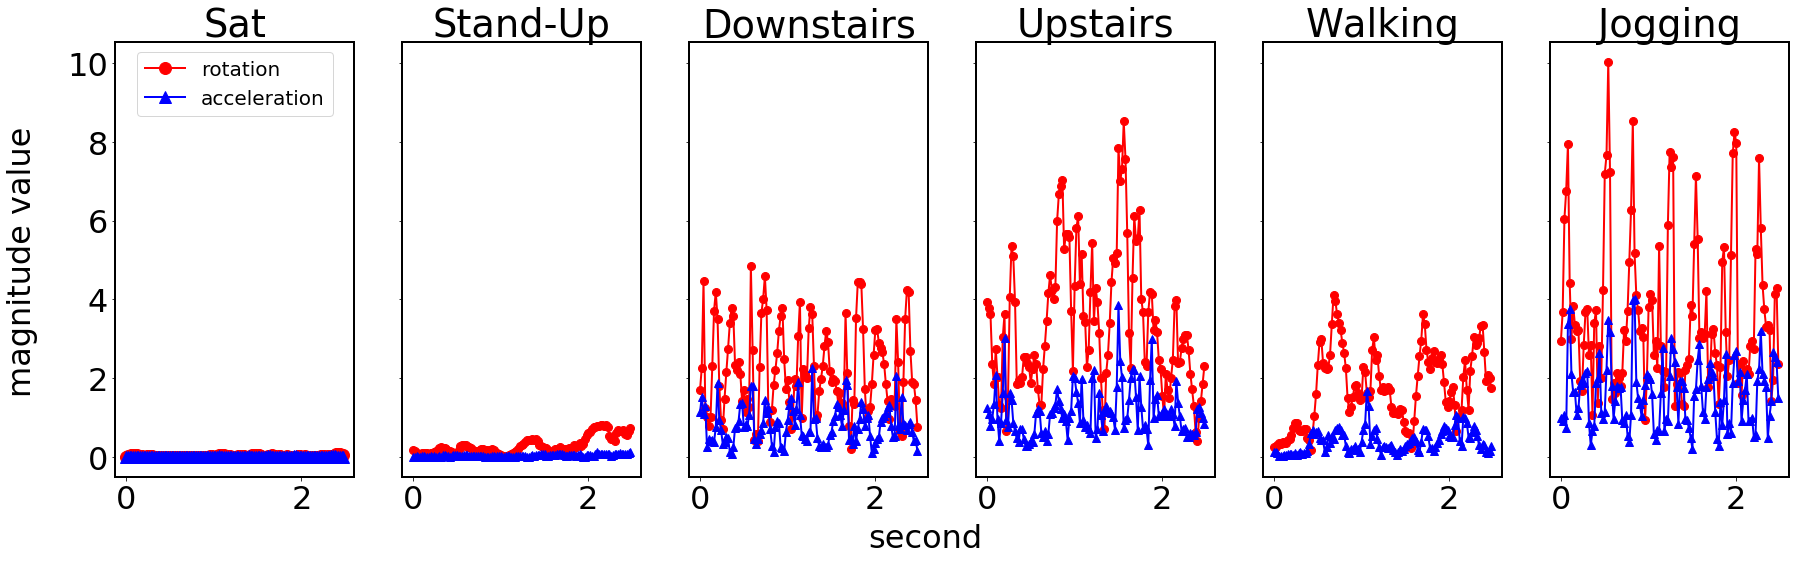

In [ ]:
act_data = np.zeros((6,points))
fig, ax = plt.subplots(1, 6, sharex='col', sharey='row')
uid = 12 # We have 24 users in the dataset, uid can be selected from {0,1,...23}
for i in np.unique(dataset["act"]):
    i =int(i)
    data = dataset[(dataset["id"] == uid) & (dataset["act"] == i)]
    acc = data["userAcceleration"].values
    rot = data["rotationRate"].values
    acc = acc[:points]
    rot = rot[:points]

    if i!=0:
        ax[i].plot(x_ticks, rot, "ro-", linewidth=2, markersize=8)
        ax[i].plot(x_ticks, acc, "b^-", linewidth=2, markersize=8)
    else:
        ax[i].plot(x_ticks, rot, "ro-", linewidth=2, markersize=12, label=lbl[0])
        ax[i].plot(x_ticks, acc, "b^-", linewidth=2, markersize=12, label=lbl[1])

    ax[i].set_title(act_lbl[i])
plt.setp(ax, yticks=np.arange(0, 11, 2))
fig.text(0.5, 0.004, 'second', ha='center')
fig.text(0.075, 0.5, 'magnitude value', va='center', rotation='vertical', )
ax[0].legend(loc="upper center", fontsize = 20)

## B. Examine the second dataset

In classical machine learning, a feature extraction process is required that converts the raw data into informative features that the model can understand. This process, also known as feature engineering is a time consuming and creative task. We will skip this part by using the [Human Activity Recognition Using Smartphones Data Set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) that includes pre-computed features in fixed-width sliding windows of 2.56 second and 50% overlap (128 readings/window).

The data directory includes a `train.csv` file that will be used for training the model, and a `test.csv` file that will be used for validating the model's performance.
Examine the dataset to get an idea of its structure.

## Load the dataset

Load the features of the train set and print the first 5 rows.

In [ ]:
def read_data(path, filename):
    return pd.read_csv(os.path.join(path, filename))

df = read_data('../input/human-activity-recognition-with-smartphones', 'train.csv')
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


Now load the labels (ground truth) of the train set and print the first five rows. Remember, the labels (listed in file `activity_labels.txt`) are:

1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying

In [ ]:
df[['Activity']].head()

,Activity
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


Now that we know how to load individual files, it's time to load the complete dataset and save it under the following four variables:
- `train_X`: features used to train the model
- `train_y`: labels used to train the model
- `test_X`: features used to validate the model
- `test_y`: labels used to validate the model

In [ ]:
def load_dataset(label_dict):
    train_X = read_data('../input/human-activity-recognition-with-smartphones', 'train.csv').values[:,:-2]
    train_y = read_data('../input/human-activity-recognition-with-smartphones', 'train.csv')['Activity']
    train_y = train_y.map(label_dict).values
    test_X = read_data('../input/human-activity-recognition-with-smartphones', 'test.csv').values[:,:-2]
    test_y = read_data('../input/human-activity-recognition-with-smartphones', 'test.csv')
    test_y = test_y['Activity'].map(label_dict).values
    return(train_X, train_y, test_X, test_y)
label_dict = {'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'SITTING':3, 'STANDING':4, 'LAYING':5}
train_X, train_y, test_X, test_y = load_dataset(label_dict)

## Choose a model

We will choose Random Forest as a model with default parameters and 100 number of estimators (`n_estimators` parameter).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

## Train the model

Train the model using the features from train set (`train_X`) and the labels as ground truth (`train_y`).

In [ ]:
train_X.shape

(7352, 561)

In [ ]:
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluate the model

Use the trained model to predict the motion activity using the features from test set (`test_X`). Predictions will be saved into `yhat` array.

In [ ]:
yhat = model.predict(test_X)
yhat

array([4, 4, 4, ..., 1, 1, 1])

Print a classification report by comparing the predictions (`yhat`) with the ground truth (`test_y`).

What is the difference between precision and recall performances? What is F1 score?

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

print(classification_report(test_y, yhat, target_names=target_names))

                    precision    recall  f1-score   support

           Walking       0.89      0.97      0.93       496
  Walking Upstairs       0.90      0.91      0.91       471
Walking Downstairs       0.96      0.85      0.90       420
           Sitting       0.90      0.89      0.90       491
          Standing       0.90      0.91      0.91       532
            Laying       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947



## More

Note that this is just a simplified version and excludes other important steps such as experiment with other models, apply parameter tuning, evaluate using cross validation etc.

Feel free to experiment with different models (e.g. Logistic Regression, SVM or XGBoost) and/or different model parameters (e.g. `n_estimators`, `max_depth` or `min_samples_split`). What is the impact on the model performance?

## References

- [MotionSense Data Set](https://github.com/mmalekzadeh/motion-sense)
- [Human Activity Recognition Using Smartphones Data Set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)
- [Scikit-Learn: Machine Learning in Python](http://scikit-learn.org/stable/)